In [1]:
%matplotlib widget

from PIL import Image
import os
import torch
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from tqdm import tqdm
import sys
import copy
import math
import open3d as o3d
from segment_anything import sam_model_registry, SamPredictor

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
np.random.seed(5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


base_path = r"D:\Study\Master Studies\25-26 WS\1-MR\2-Projects\myProject\1"
image_dir = os.path.join(base_path, r"Data\rect_left")
gt_depth_dir = os.path.join(base_path, r"Data\GT_left\depth_maps")


output_mask_dir = os.path.join(base_path, r"outputs\sam_masks")
test_image_dir = os.path.join(base_path, r"outputs\test\image")
test_mask_dir  = os.path.join(base_path, r"outputs\test\sam_mask")
fused_output_dir = os.path.join(base_path, r"outputs\fused_depth")

for d in [output_mask_dir, test_image_dir, test_mask_dir, fused_output_dir]:
    os.makedirs(d, exist_ok=True) 

Using device: cuda


In [3]:
def load_gt_depth_tiff(gt_path):
    gt = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
    if gt is None:
        raise FileNotFoundError(f"GT file not found: {gt_path}")
    gt = gt.astype(np.float32)
    return gt


sam_checkpoint = os.path.join(base_path, r"checkpoints\sam_vit_b_01ec64.pth")
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

def generate_mask_with_sam_manual_points(image_path, predictor, save_path=None):
    """
    OpenCV GUI for selecting 3 points on the image to generate a mask using SAM.
    """

    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)
    
    clicked_points = []
    display_image = image_bgr.copy()
    window_name = "SAM - Click 3 points (Tip -> Middle -> End)"
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal clicked_points, display_image
        if event == cv2.EVENT_LBUTTONDOWN:
            clicked_points.append([x, y])
            print(f"Point {len(clicked_points)}: ({x}, {y})")
            

            cv2.circle(display_image, (x, y), 5, (0, 0, 255), -1)
            

            cv2.putText(display_image, str(len(clicked_points)), 
                       (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                       0.7, (0, 0, 255), 2)
            

            cv2.imshow(window_name, display_image)
            
            if len(clicked_points) >= 3:
                cv2.putText(display_image, "3 points selected! Press ENTER to confirm", 
                           (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 
                           0.8, (0, 255, 0), 2)
                cv2.imshow(window_name, display_image)
    

    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 1000, 800)
    cv2.setMouseCallback(window_name, mouse_callback)
    
    print("Click 3 points on the image. Press ENTER when done, ESC to cancel.")
    

    cv2.imshow(window_name, display_image)
    

    while True:
        key = cv2.waitKey(1) & 0xFF
        
        if key == 13:  # ENTER
            break

        elif key == 27:  # ESC
            print("Selection cancelled by user.")
            cv2.destroyAllWindows()
            return None, None
        

        if len(clicked_points) >= 3:
            pass  
    
    cv2.destroyAllWindows()
    

    if len(clicked_points) < 3:
        print(f"Only {len(clicked_points)} points selected. Need 3 points.")
        return None, None
    
  
    points = np.array(clicked_points)
    point_labels = np.ones(len(points), dtype=int)
    

    masks, scores, _ = predictor.predict(
        point_coords=points,
        point_labels=point_labels,
        multimask_output=True
    )
    best_mask = masks[np.argmax(scores)]
    
    if save_path:
        cv2.imwrite(save_path, (best_mask * 255).astype(np.uint8))
        print(f"Mask saved to: {save_path}")
    
    return best_mask, points


d:\Study\Master Studies\25-26 WS\1-MR\2-Projects\myProject\1\.venv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

### Feature Extraction: Extract the "useful information" based on mask  
Here, 4 image vision cues for depth anything are selected, which are suggested in some references papers: Specular, shading, local Contrast, Gradient. Based on the binary masks after semantic segmentation, these 4 cues can explictly tell the depth estimation network: where is surgical tool, where is the human tissue, be careful when do the depth estimation, because they have different characteristics. 

In [4]:
def compute_reliability_and_features(img_path, mask_path):

    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    mask = (cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 127).astype(np.float32)
    mask_blur = cv2.GaussianBlur(mask, (15,15), 5)


    h, s, v = cv2.split(img_hsv)
    specular = ((v > 220) & (s < 50)).astype(np.float32)


    shading = cv2.GaussianBlur(img_gray, (0,0), 15)
    shading = (shading - shading.min()) / (shading.max() + 1e-8)


    local_std = cv2.blur(img_gray**2,(7,7)) - cv2.blur(img_gray,(7,7))**2
    local_std = np.sqrt(np.maximum(local_std, 0))
    local_std = local_std / (local_std.max() + 1e-8)


    gx = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx**2 + gy**2)
    grad = grad / (grad.max() + 1e-8)


    w_shading = 0.5
    w_texture = 0.3
    w_edge = 0.2
    w_spec = 0.8


    R = (w_shading * shading + w_texture * local_std + w_edge * grad) * (1 - mask_blur)
    

    R = R * (1 - w_spec * specular)
    R = np.clip(R, 0, 1)


    features = {
        "Shading": shading,
        "Texture": local_std,
        "Edge": grad,
        "Specular": specular
    }
    
    return R.astype(np.float32), mask.astype(np.float32), features

In [5]:
def apply_reliability_to_image(img, reliability):
    """
    img: BGR uint8
    reliability: [0,1]
    """
    img_f = img.astype(np.float32) / 255.0
    img_w = img_f * reliability[..., None]
    img_w = np.clip(img_w * 255.0, 0, 255).astype(np.uint8)
    return img_w

### Visualization

In [6]:
def visualize_feature_histogram(features, mask):

    instrument = mask > 0.5
    tissue = mask <= 0.5

    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    fig.suptitle("Feature Discrimination: Instrument vs Tissue")

    for ax, (name, feat) in zip(axes, features.items()):
        inst_vals = feat[instrument]
        tis_vals  = feat[tissue]

        means = [inst_vals.mean(), tis_vals.mean()]
        stds  = [inst_vals.std(),  tis_vals.std()]

        ax.bar(["Instrument", "Tissue"], means, yerr=stds, capsize=5)
        ax.set_title(name)
        ax.set_ylabel("Feature Value")

    plt.tight_layout()
    plt.show()


In [7]:
def visualize_comprehensive(img_path, depth_raw, depth_guided, depth_gt, reliability, mask):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    def norm(d):
        d = np.nan_to_num(d)
        return (d - d.min()) / (d.max() - d.min() + 1e-8)


    err_raw = np.abs(depth_raw - depth_gt)
    err_raw[depth_gt <= 0] = 0
    err_weighted = err_raw * reliability


    img_weighted = apply_reliability_to_image(cv2.imread(img_path), reliability)
    

    fig, axes = plt.subplots(2, 5, figsize=(24, 10))
    fig.suptitle(f"Analysis: {os.path.basename(img_path)}", fontsize=14)


    axes[0,0].imshow(img)
    axes[0,0].set_title("RGB Image")

    axes[0,1].imshow(mask, cmap='gray')
    axes[0,1].set_title("SAM Mask (Binary)")

    axes[0,2].imshow(img_weighted, cmap=None)
    axes[0,2].set_title("Guided Input")

    axes[0,3].imshow(norm(depth_gt), cmap='inferno')
    axes[0,3].set_title("GT Depth")

    axes[0,4].imshow(reliability, cmap='magma')
    axes[0,4].set_title("Reliability Map")


    axes[1,0].imshow(norm(depth_raw), cmap='inferno')
    axes[1,0].set_title("Pred Depth (Raw)")

    axes[1,1].imshow(norm(depth_guided), cmap='inferno')
    axes[1,1].set_title("Pred Depth (Guided)")

    axes[1,2].imshow(norm(err_raw), cmap='jet')
    axes[1,2].set_title("Abs Error (Raw)")

    axes[1,3].imshow(norm(err_weighted), cmap='jet')
    axes[1,3].set_title("Weighted Error")

    axes[1,4].axis("off") 

    for ax in axes.flatten():
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Evaluation Matrics

In [8]:
def compute_depth_metrics(
    depth_pred,
    depth_gt,
    valid_mask,
    reliability=None
):


    pred = depth_pred[valid_mask]
    gt   = depth_gt[valid_mask]

    eps = 1e-8
    diff = pred - gt
    abs_diff = np.abs(diff)

    metrics = {}


    metrics["RMSE"] = np.sqrt(np.mean(diff ** 2))
    metrics["MAE"]  = np.mean(abs_diff)
    metrics["AbsRel"] = np.mean(abs_diff / (gt + eps))


    if reliability is not None:
        w = reliability[valid_mask]

        metrics["wRMSE"] = np.sqrt(
            np.sum(w * diff ** 2) / (np.sum(w) + eps)
        )

        metrics["wAbsRel"] = np.sum(
            w * abs_diff / (gt + eps)
        ) / (np.sum(w) + eps)

    return metrics


### Tool incline or not evaluation

In [9]:

def sample_depth_robust(depth_map, x, y, r=3):
    """
    Sample median depth in a local window to suppress noise/specular artifacts
    """
    H, W = depth_map.shape
    x0, x1 = max(0, x - r), min(W, x + r + 1)
    y0, y1 = max(0, y - r), min(H, y + r + 1)

    patch = depth_map[y0:y1, x0:x1]
    patch = patch[np.isfinite(patch)]

    if patch.size == 0:
        return np.nan

    return np.median(patch)

In [10]:
def analyze_tool_tilt_from_pred(points, depth_map, eps=1e-3):
    """
    Analyze tool tilt using predicted depth only.
    points: Nx2, order = [tip, middle, end]
    depth_map: predicted depth (raw or guided)
    """

    depths = []
    for (x, y) in points:
        z = sample_depth_robust(depth_map, int(x), int(y), r=3)
        depths.append(z)

    d_tip, d_mid, d_end = depths

    if np.any(np.isnan(depths)):
        return {
            "valid": False,
            "reason": "invalid_depth_sample",
            "depths": depths
        }

    increasing = (d_tip + eps < d_mid) and (d_mid + eps < d_end)
    decreasing = (d_tip > d_mid + eps) and (d_mid > d_end + eps)

    if increasing:
        return {
            "valid": True,
            "is_tilted": True,
            "direction": "away_from_camera",
            "depths": depths
        }

    if decreasing:
        return {
            "valid": True,
            "is_tilted": True,
            "direction": "towards_camera",
            "depths": depths
        }

    return {
        "valid": True,
        "is_tilted": False,
        "direction": "approximately_parallel_or_uncertain",
        "depths": depths
    }

### Main Loop

xFormers not available
xFormers not available


C:\Users\DELL\AppData\Local\Temp\ipykernel_23356\1571082320.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_file, map_locati

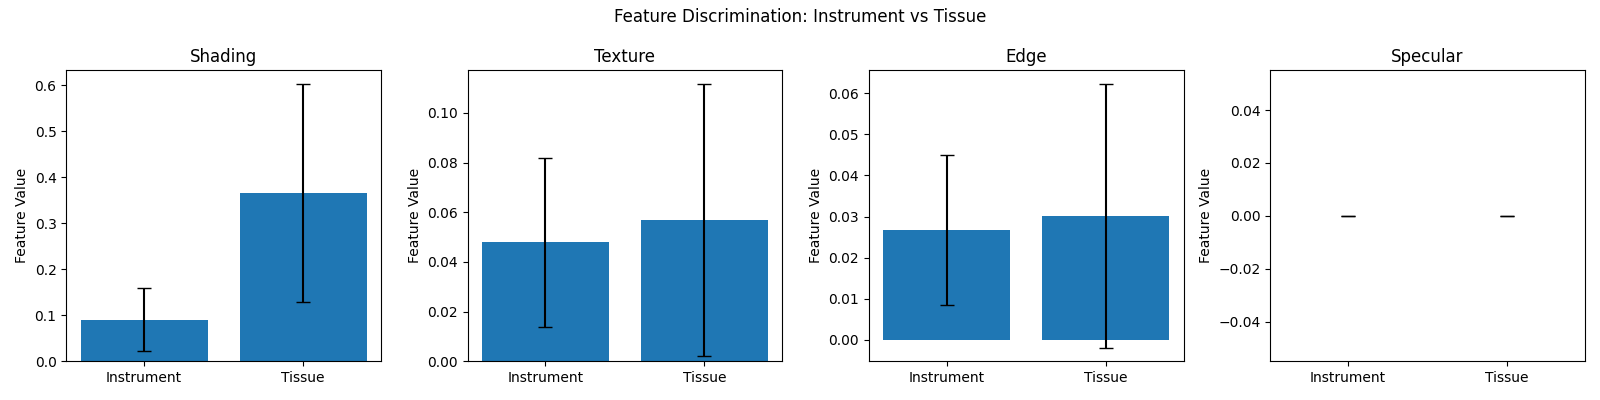


    [00042.png]

    --- Raw Input ---
    RMSE:      0.0984
    MAE:       0.0519
    AbsRel:    0.1628
    wRMSE:     0.0709
    wAbsRel:   0.1142

    --- Guided Input ---
    RMSE:      0.0939
    MAE:       0.0594
    AbsRel:    0.2275
    wRMSE:     0.0693
    wAbsRel:   0.2133
    


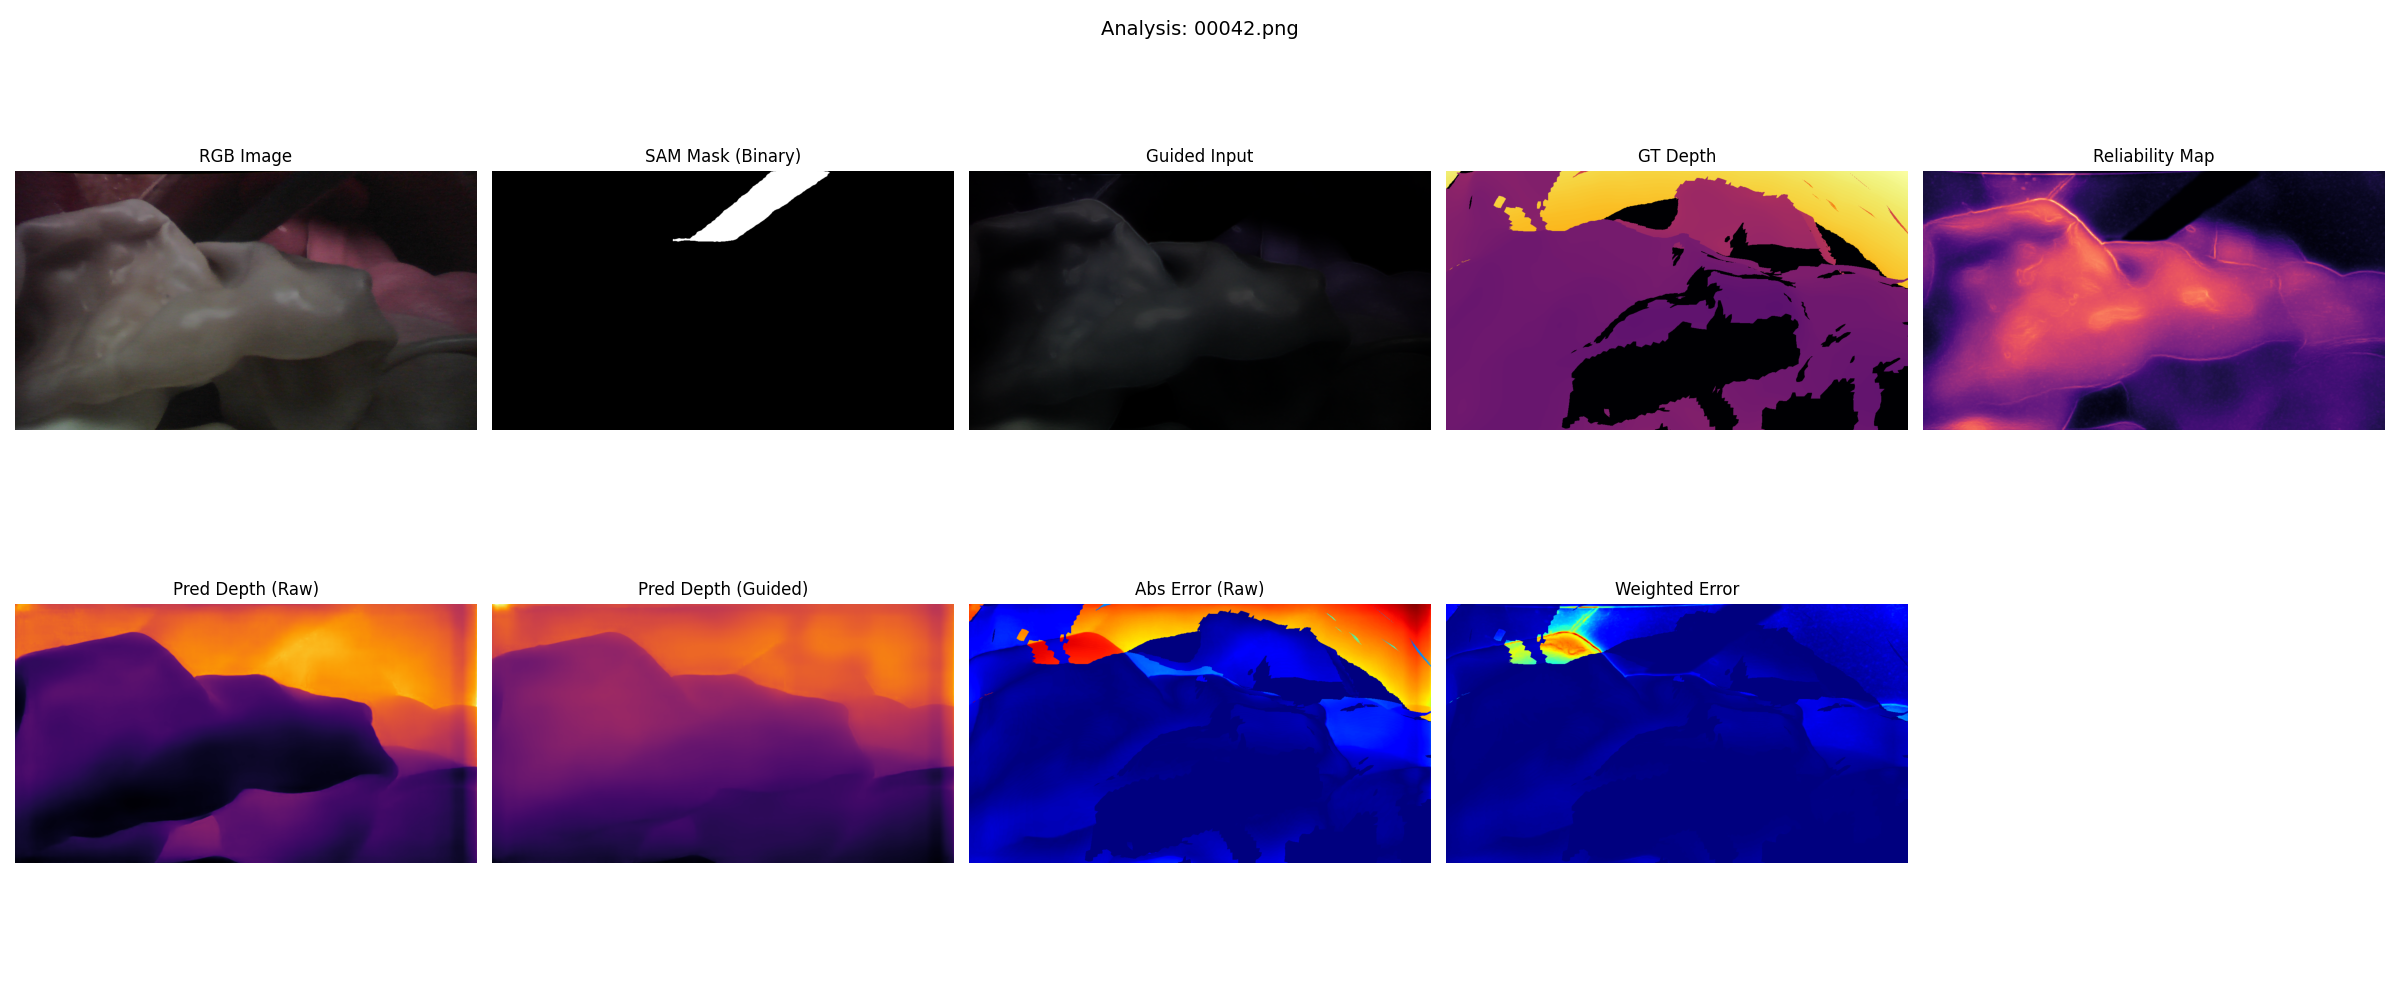

 33%|███▎      | 1/3 [00:02<00:04,  2.13s/it]

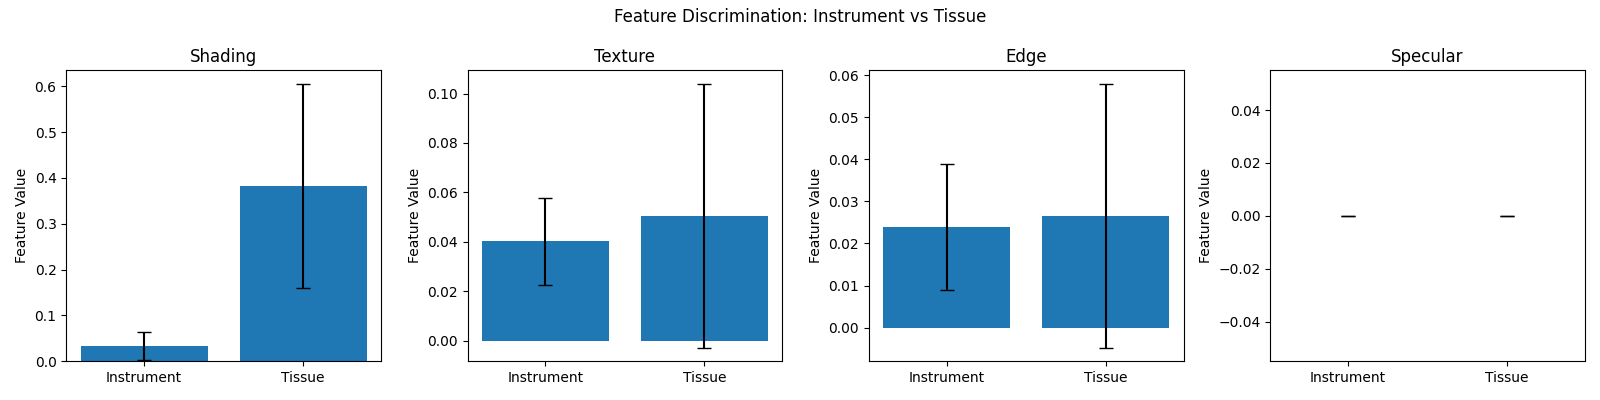


    [00029.png]

    --- Raw Input ---
    RMSE:      0.0906
    MAE:       0.0486
    AbsRel:    0.1886
    wRMSE:     0.0684
    wAbsRel:   0.1647

    --- Guided Input ---
    RMSE:      0.0846
    MAE:       0.0450
    AbsRel:    0.1734
    wRMSE:     0.0627
    wAbsRel:   0.1597
    


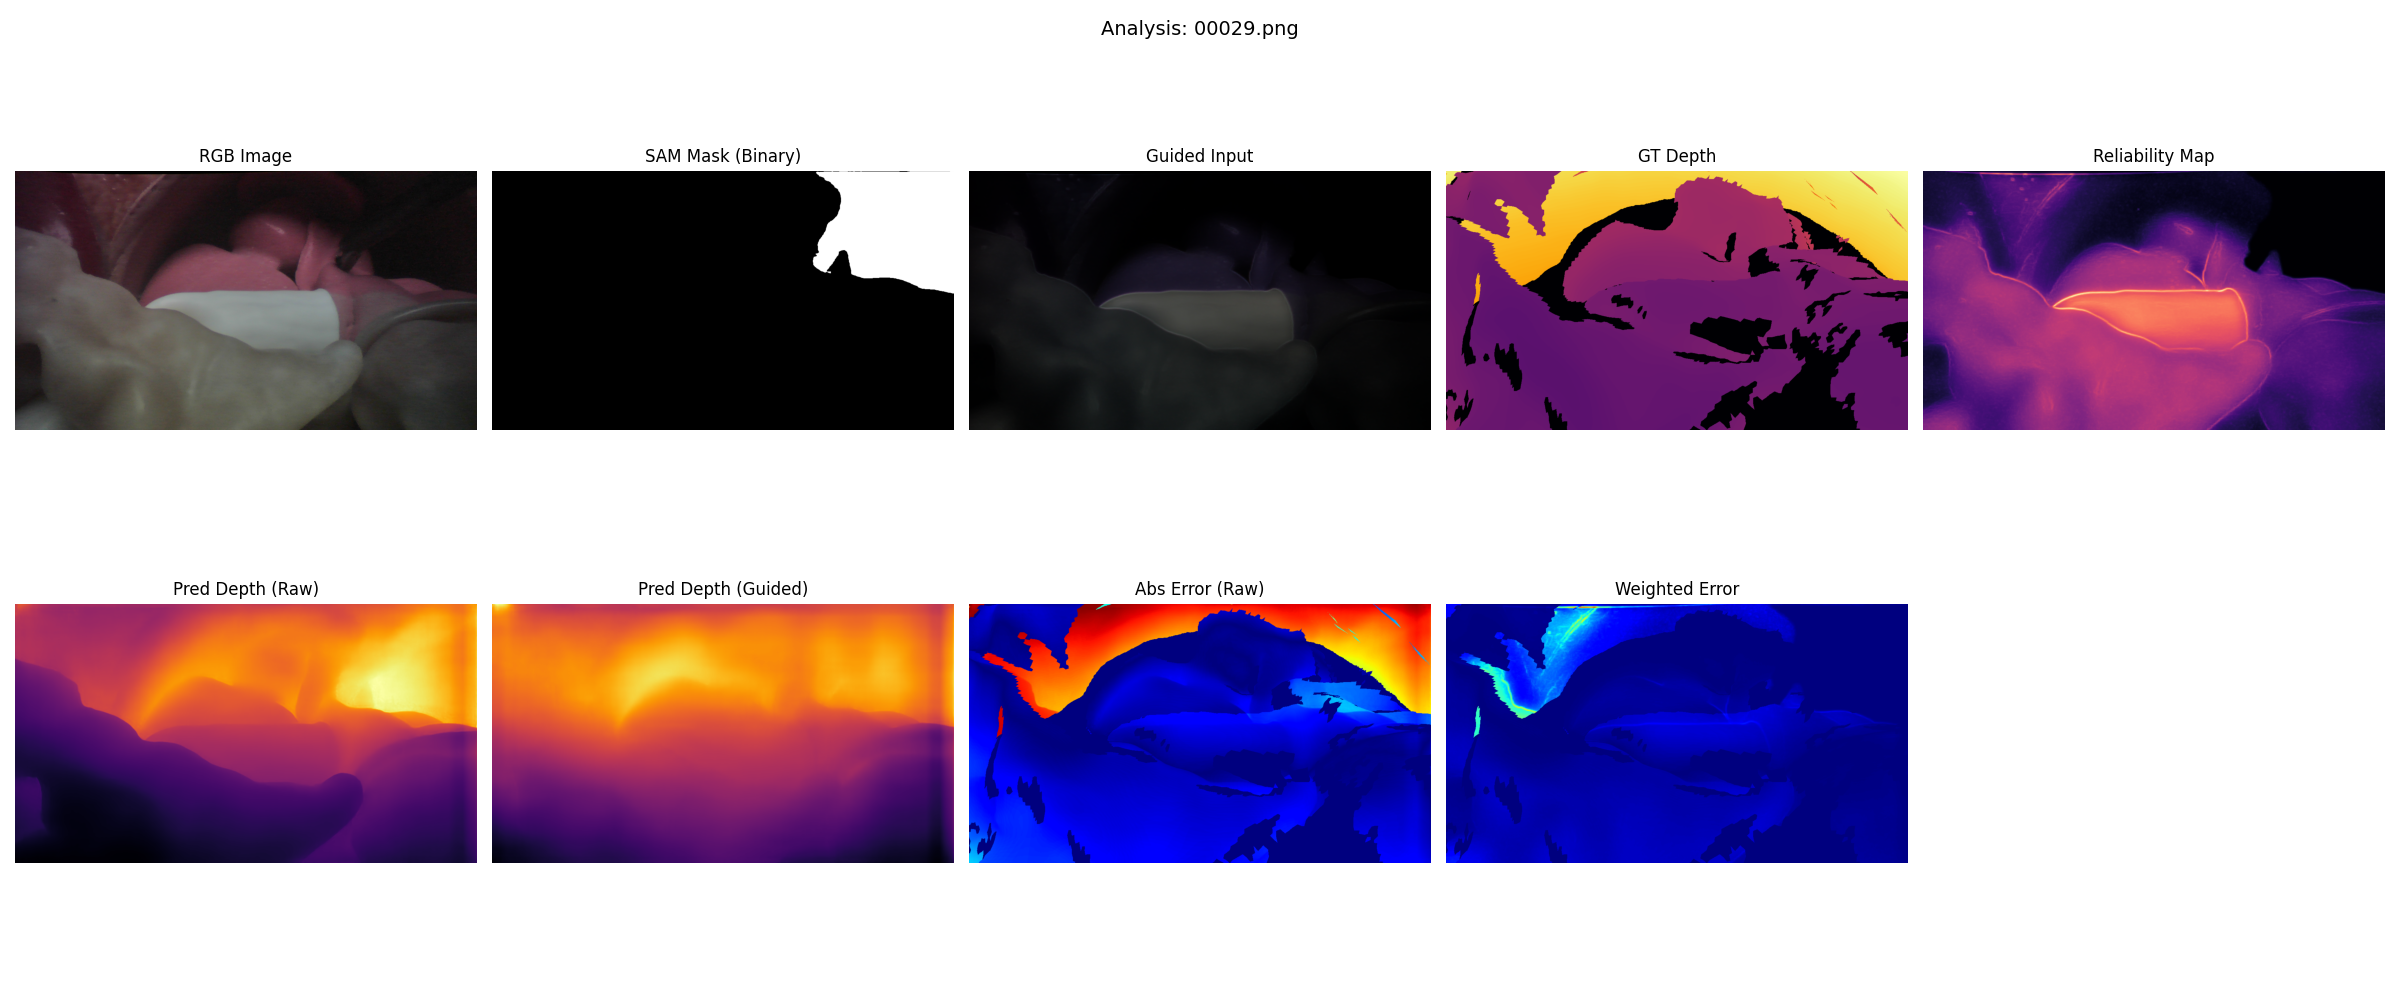

 67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

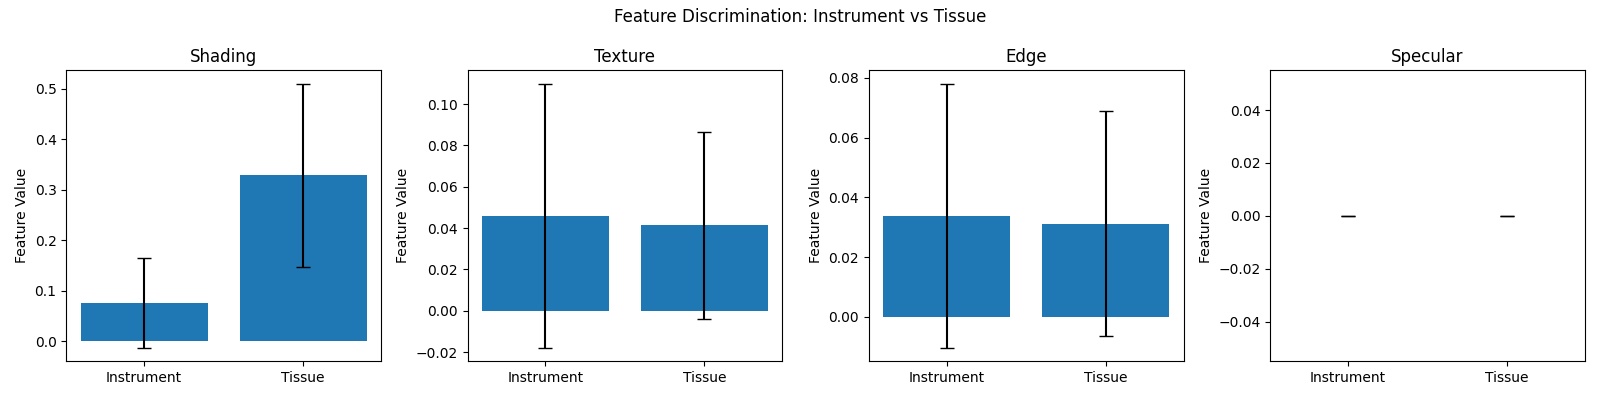


    [00006.png]

    --- Raw Input ---
    RMSE:      0.0898
    MAE:       0.0426
    AbsRel:    0.1440
    wRMSE:     0.0636
    wAbsRel:   0.1096

    --- Guided Input ---
    RMSE:      0.0922
    MAE:       0.0458
    AbsRel:    0.1647
    wRMSE:     0.0658
    wAbsRel:   0.1376
    


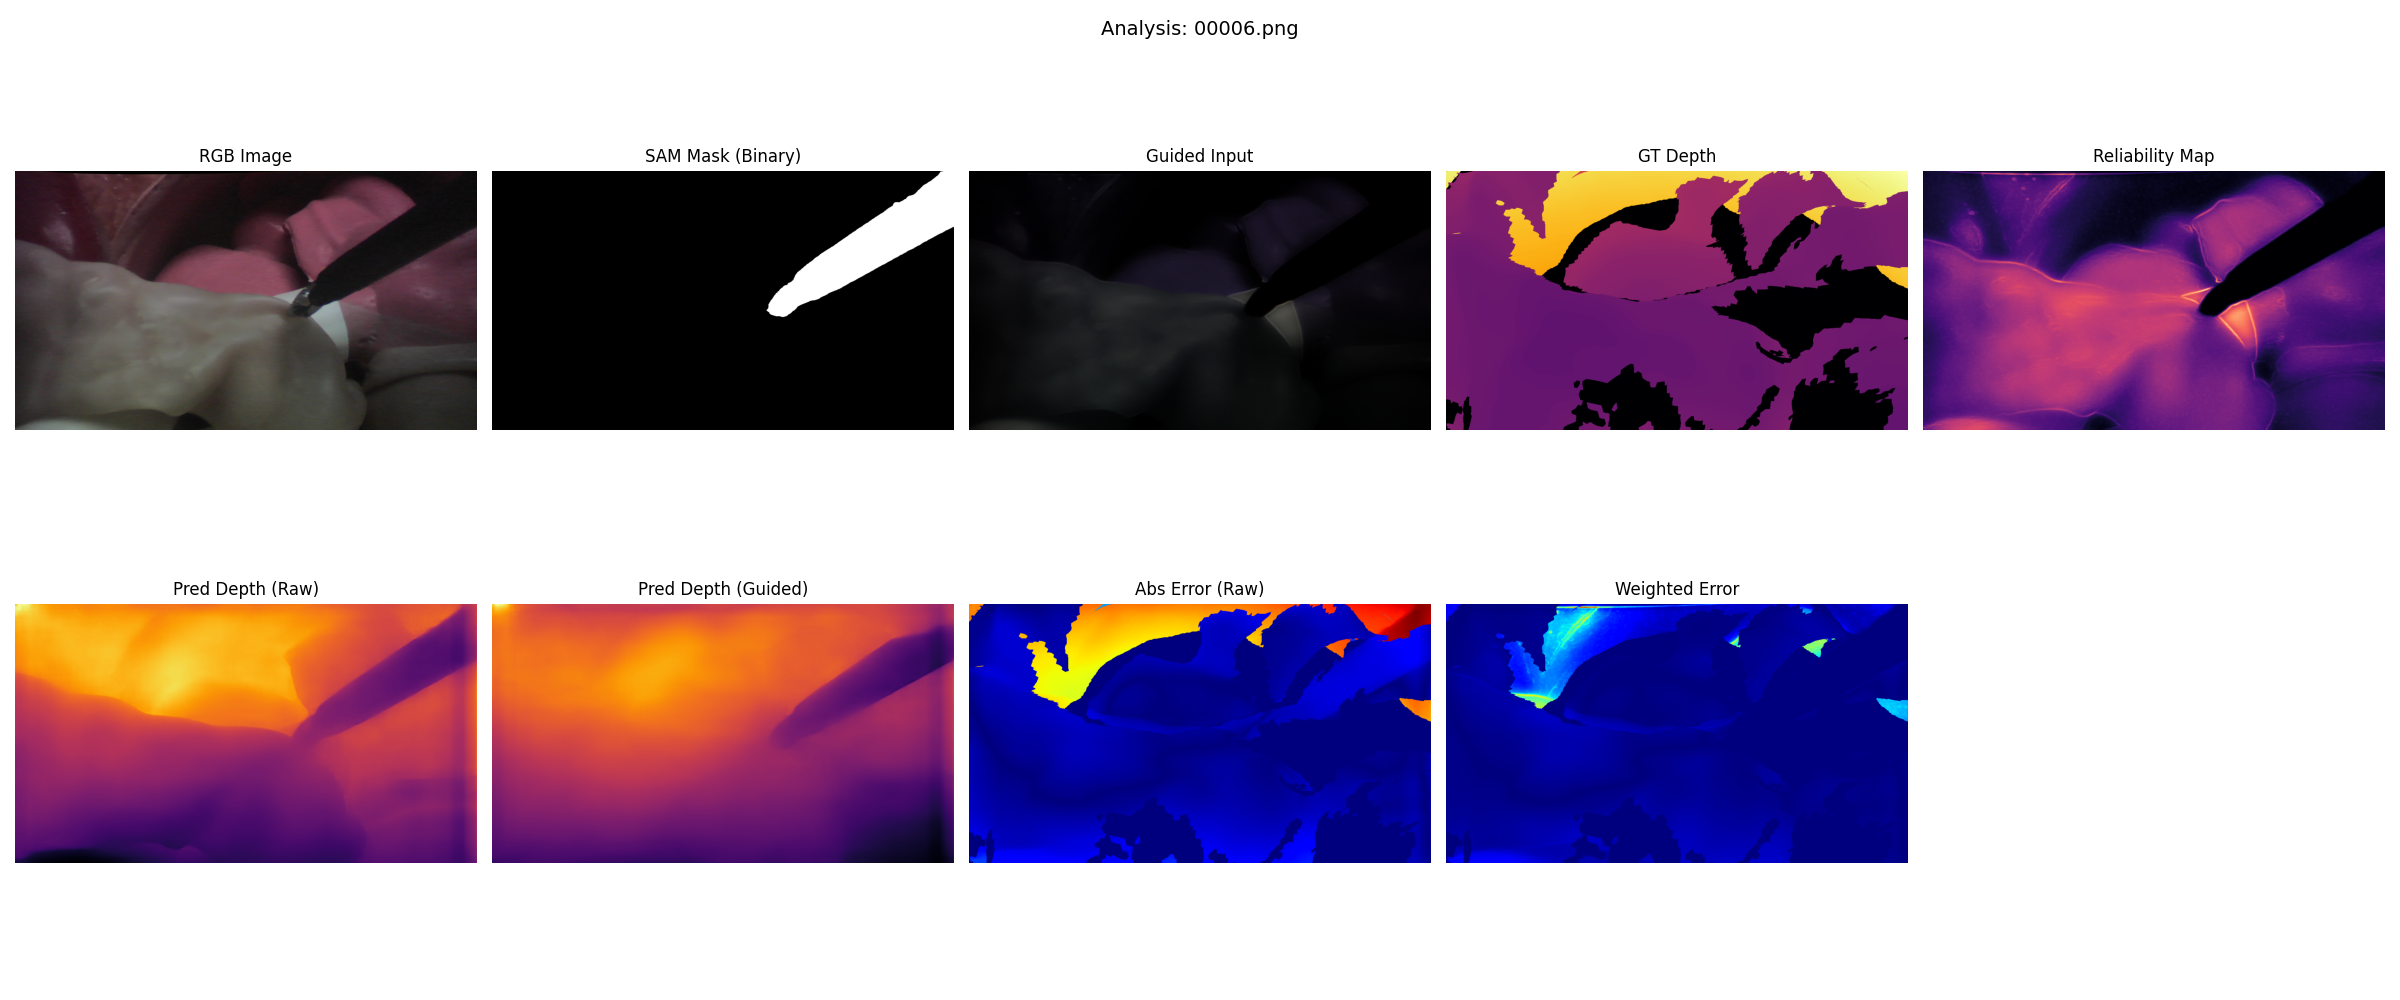

100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


In [11]:
sys.path.append(os.path.join(base_path, r"Depth-Anything-V2\metric_depth"))
from depth_anything_v2.dpt import DepthAnythingV2

checkpoint_file = os.path.join(base_path, r"checkpoints\depth_anything_v2_metric_hypersim_vitb.pth")
model = DepthAnythingV2(
    encoder='vitb',
    features=128,
    out_channels=[96, 192, 384, 768]
)
model.load_state_dict(torch.load(checkpoint_file, map_location='cpu'))
model.to(device).eval()

val_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
sample_files = np.random.choice(val_files, min(3, len(val_files)), replace=False)

for fname in tqdm(sample_files):


    img_path = os.path.join(test_image_dir, fname)
    if not os.path.exists(img_path):
        shutil.copy(os.path.join(image_dir, fname), img_path)

    mask_path = os.path.join(test_mask_dir, fname)

    if not os.path.exists(mask_path):
        mask_sam, points = generate_mask_with_sam_manual_points(
            img_path, predictor, save_path=mask_path)
    else:
        mask_sam = (cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 127).astype(np.uint8)
        points = None


    raw_img = cv2.imread(img_path)

    gt_path = os.path.join(gt_depth_dir, fname.replace(".png", ".tiff"))
    depth_gt = load_gt_depth_tiff(gt_path)
    if depth_gt.max() > 50:
        depth_gt /= 1000.0


    reliability_map, mask_float, features = compute_reliability_and_features(
        img_path, mask_path
    )

    instrument_mask = (mask_float > 0.5).astype(np.uint8)
    valid_tissue = (depth_gt > 0) & (instrument_mask == 0)


    visualize_feature_histogram(features, mask_float)


    depth_raw = model.infer_image(raw_img) 

    img_weighted = apply_reliability_to_image(raw_img, reliability_map)
    depth_guided = model.infer_image(img_weighted) 


    if points is not None:
        tilt_info = analyze_tool_tilt_from_pred(points, depth_guided)

        print("\n[Tool Tilt Analysis - Predicted Depth]")
        if tilt_info["valid"]:
            d_tip, d_mid, d_end = tilt_info["depths"]
            print(f"  Depths: Tip={d_tip:.4f}, Mid={d_mid:.4f}, End={d_end:.4f}")
            print(f"  Is tilted: {tilt_info['is_tilted']}")
            print(f"  Direction: {tilt_info['direction']}")
        else:
            print("  Tilt analysis failed:", tilt_info["reason"])


    if valid_tissue.sum() > 10:
        scale = (
            np.median(depth_gt[valid_tissue]) /
            (np.median(depth_raw[valid_tissue]) + 1e-8)
        )
        depth_raw *= scale
        depth_guided *= scale


    metrics_raw = compute_depth_metrics(
        depth_raw,
        depth_gt,
        valid_tissue,
        reliability=reliability_map
    )

    metrics_guided = compute_depth_metrics(
        depth_guided,
        depth_gt,
        valid_tissue,
        reliability=reliability_map
    )

    print(f"""
    [{fname}]

    --- Raw Input ---
    RMSE:      {metrics_raw["RMSE"]:.4f}
    MAE:       {metrics_raw["MAE"]:.4f}
    AbsRel:    {metrics_raw["AbsRel"]:.4f}
    wRMSE:     {metrics_raw["wRMSE"]:.4f}
    wAbsRel:   {metrics_raw["wAbsRel"]:.4f}

    --- Guided Input ---
    RMSE:      {metrics_guided["RMSE"]:.4f}
    MAE:       {metrics_guided["MAE"]:.4f}
    AbsRel:    {metrics_guided["AbsRel"]:.4f}
    wRMSE:     {metrics_guided["wRMSE"]:.4f}
    wAbsRel:   {metrics_guided["wAbsRel"]:.4f}
    """)


    visualize_comprehensive(
        img_path,
        depth_raw,
        depth_guided,
        depth_gt,
        reliability_map,
        mask_sam
    )
